In [119]:
from openparticle.qubit_mappings import op_qubit_map
from openparticle import ParticleOperator, Fock
from openparticle.hamiltonians.yukawa_hamiltonians import yukawa_Hamiltonian
from openparticle.utils import get_fock_basis, generate_matrix
import numpy as np
import cirq
import matplotlib.pyplot as plt

from random import sample

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))
from src.lobe.asp import get_target_state, add_prepare_circuit
from src.lobe.rescale import bosonically_rescale_terms, get_numbers_of_bosonic_operators_in_terms, get_number_of_active_bosonic_modes
from src.lobe.system import System
from src.lobe.lobe_circuit import lobe_circuit
from src.lobe.block_encoding import add_lobe_oracle
from src.lobe.lcu import LCU
from src.lobe.addition import add_classical_value_incrementers
from src.lobe.multiplexed_rotations import get_decomposed_multiplexed_rotation_circuit
from colors import *
from symmer import PauliwordOp

In [11]:
def generate_circuit(operator):

    terms = operator.to_list()

    bosonically_rescaled_terms, bosonic_rescaling_factor = bosonically_rescale_terms(terms, 1)
    coefficients = [term.coeff for term in bosonically_rescaled_terms]

    norm = sum(np.abs(coefficients))
    target_state = get_target_state(coefficients)
    asp_rescaling_factor = (bosonic_rescaling_factor * norm)

    number_of_modes = max([term.max_mode() for term in terms]) + 1

    number_of_ancillae = (
        1000  # Some arbitrary large number with most ancilla disregarded
    )
    number_of_index_qubits = max(int(np.ceil(np.log2(len(terms)))), 1)
    number_of_rotation_qubits = max(get_number_of_active_bosonic_modes(terms)) + 1
    


    # Declare Qubits
    validation = cirq.LineQubit(0)
    clean_ancillae = [cirq.LineQubit(i + 1) for i in range(number_of_ancillae)]
    rotation_qubits = [
        cirq.LineQubit(i + 1 + number_of_ancillae)
        for i in range(number_of_rotation_qubits)
    ]
    index_register = [
        cirq.LineQubit(i + 1 + number_of_ancillae + number_of_rotation_qubits)
        for i in range(number_of_index_qubits)
    ]
    system = System(
        number_of_modes=number_of_modes,
        maximum_occupation_number=1,
        number_of_used_qubits=1
        + number_of_ancillae
        + number_of_rotation_qubits
        + number_of_index_qubits,
        has_fermions=operator.has_fermions,
        has_antifermions=operator.has_antifermions,
        has_bosons=operator.has_bosons,
    )

    #### ASP Circuit Generation
    ASP_numerics = {
        "left_elbows": 0,
        "right_elbows": 0,
        "rotations": 0,
        "ancillae_tracker": [1 + number_of_rotation_qubits - 1 + number_of_index_qubits],
        "angles": [],
        "number_of_nonclifford_rotations": 0,
        "rescaling_factor": asp_rescaling_factor,
        "number_of_modes": number_of_modes,
        "maximum_bosonic_occupation": 1,
        "maximum_number_of_active_bosonic_modes": number_of_rotation_qubits - 1,
        "number_of_terms": len(terms)
    }
    circuit = cirq.Circuit()
    circuit.append(cirq.I.on_each(*system.fermionic_register))
    circuit.append(cirq.I.on_each(*system.antifermionic_register))
    for bosonic_reg in system.bosonic_system:
        circuit.append(cirq.I.on_each(*bosonic_reg))
    circuit.append(cirq.X.on(validation))
    circuit += add_prepare_circuit(
        index_register,
        target_state=target_state,
        numerics=ASP_numerics,
        clean_ancillae=clean_ancillae
    )
    circuit += add_lobe_oracle(
        bosonically_rescaled_terms,
        validation,
        index_register,
        system,
        rotation_qubits,
        clean_ancillae,
        perform_coefficient_oracle=False,
        numerics=ASP_numerics,
    )
    circuit += add_prepare_circuit(
        index_register,
        target_state=target_state,
        dagger=True,
        numerics=ASP_numerics,
        clean_ancillae=clean_ancillae
    )
    ASP_numerics["number_of_ancillae"] = max(ASP_numerics["ancillae_tracker"])
    ASP_numerics["number_of_qubits"] = max(ASP_numerics["ancillae_tracker"]) + system.number_of_system_qubits
    for angle in ASP_numerics["angles"]:
        angle = np.abs(angle)
        if not np.isclose(angle%np.pi/4, 0):
            ASP_numerics["number_of_nonclifford_rotations"] += 1
    
    return {
        "ASP": ASP_numerics 
    }

In [18]:
lobe_circuit(ParticleOperator('b0') + ParticleOperator('b0^'))[0]

0: ──────X─────────────@───X───────(0)─────────────────────@─────X───────(0)───────────────────
                       │   │       │                       │     │       │
1: ────────────────────X───@───@───X───────────────────────X─────@───@───X─────────────────────
                       │       │   │                       │         │   │
2: ──────────────X─────@───────┼───@─────@───────X─────X───@─────────┼───@─────@───────X───────
                 │     │       │         │       │     │   │         │         │       │
1001: ───────────┼─────┼───────┼─────────Ry(0)───┼─────┼───┼─────────┼─────────Ry(0)───┼───────
                 │     │       │                 │     │   │         │                 │
1002: ───────H───(0)───┼───────┼─────────────────(0)───@───┼─────────┼─────────────────@───H───
                       │       │                           │         │
1003: ───I─────────────@───────X───────────────────────────(0)───────X─────────────────────────

In [37]:
from time import time

B = 10


DATA_rots = []
DATA = []
LCU_elbows_DATA = []
smart_LCU_elbows_DATA = []
for b in range(1, B + 1):
    max_mode = B
    indices = sorted(sample(range(max_mode), b))

    operator = ParticleOperator(" ".join(f"b{index}" for index in indices[::-1]))
    operator = operator + operator.dagger()
    start = time()
    print("----{} of {}----".format(b, max(range(1, B + 1))))

    DATA.append(b - 1)
    DATA_rots.append(generate_circuit(operator + operator.dagger())['ASP']['rotations'])
    smart_LCU_elbows_DATA.append(2 * b)
    LCU_elbows_DATA.append(op_qubit_map(operator).n_terms)

    print("* {} (s) *".format(round(time() - start, 1)))



----1 of 10----
* 0.0 (s) *
----2 of 10----
* 0.0 (s) *
----3 of 10----
* 0.0 (s) *
----4 of 10----
* 0.0 (s) *
----5 of 10----
* 0.0 (s) *
----6 of 10----
* 0.0 (s) *
----7 of 10----
* 0.0 (s) *
----8 of 10----
* 0.0 (s) *
----9 of 10----
* 0.0 (s) *
----10 of 10----
* 0.0 (s) *


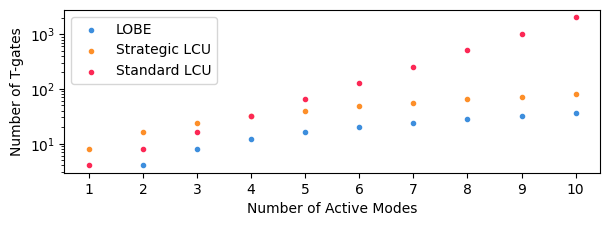

In [43]:
fig, axes = plt.subplots(1, 1, figsize=(16 / 2.54, 6 / 2.54))

active_modes = range(1, B + 1)

# numbers_of_terms_LOBE = [DATA_POINT["ASP"]["number_of_terms"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]

# left_elbows_asp = [DATA_POINT["ASP"]["left_elbows"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
# right_elbows_asp = [DATA_POINT["ASP"]["right_elbows"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
# rotations_asp = [DATA_POINT["ASP"]["rotations"] for DATA_POINT in DATA_rots]
# nonclifford_rotations_asp = [DATA_POINT["ASP"]["number_of_nonclifford_rotations"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
# rescaling_factors_asp = [DATA_POINT["ASP"]["rescaling_factor"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
# numbers_of_qubits_asp = [DATA_POINT["ASP"]["number_of_qubits"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
# numbers_of_ancillae_asp = [DATA_POINT["ASP"]["number_of_ancillae"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]

# axes[0].scatter(active_modes, DATA_rots, color=BLUE, marker='.', alpha = 1)
# # axes[0].plot(numbers_of_terms, rotations_asp, color=ORANGE, marker='.', alpha = 1)
# # axes[0].scatter(active_modes, DATA, color=ORANGE, marker='.', alpha = 1)
# # axes[0].scatter(active_modes, smart_LCU_rots_DATA, color=BLUE, marker='.', alpha = 1)
# # axes[0].scatter(active_modes, LCU_elbows_DATA, color=GREEN, marker='.', alpha = 1)
# # axes[0].plot(numbers_of_terms, rotation_upper_bound, color=RED, ls='--', alpha = 1)
# axes[0].set_ylabel("Number of Rotations")
# # axes[0].set_xlabel("Number of Terms ($L$)")
# axes[0].set_xlabel("Number of Active Modes")


axes.scatter(active_modes, 4 * np.array(DATA), color=BLUE, marker='.', alpha = 1, label = "LOBE")
axes.scatter(active_modes, 4 * np.array(smart_LCU_elbows_DATA), color=ORANGE, marker='.', alpha = 1, label = "Strategic LCU")
axes.scatter(active_modes, 4 * np.array(LCU_elbows_DATA), color=RED, marker='.', alpha = 1, label = "Standard LCU")
# # axes.plot(numbers_of_terms, elbow_upper_bound, color=RED, ls='--', alpha = 1)
axes.set_ylabel("Number of T-gates")
axes.set_xlabel("Number of Active Modes")

# axes[2].scatter(active_modes, DATA, color=BLUE, marker='.', alpha = 1)
# axes[2].scatter(active_modes, smart_LCU_rots_DATA, color=ORANGE, marker='.', alpha = 1)
# axes[2].scatter(active_modes, LCU_elbows_DATA, color=RED, marker='.', alpha = 1)
# axes[2].set_ylabel("Number of Right-Elbows")
# axes[2].set_xlabel("Number of Active Modes")

plt.tight_layout()
# axes[0].set_yscale('log')
# axes[1].set_yscale('log')
# axes[2].set_yscale('log')
axes.set_xticks(active_modes)
axes.set_yscale('log')
axes.legend()
# axes[1].set_xticks(active_modes)
# axes[2].set_xticks(active_modes)
# axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
#           fancybox=True, shadow=True, ncol=2)
# plt.savefig("../manuscript/figures/yukawa_hamiltonian_gates_vs_resolution.pdf", dpi=600)

In [86]:
def theta_angle(w, R, S, Omega):
    th = 1
    for r in range(0, R):
        th *= np.sqrt(w - r)
    for s in range(1, S + 1):
        th *= np.sqrt(w - R + s)
    return th

In [139]:
R = 2
S = 1
Omega = 3

op = ParticleOperator('a0^')**R * ParticleOperator('a0')**S


ctrl = cirq.LineQubit(0)
index = cirq.LineQubit(1)
anc = cirq.LineQubit(2)

system = [cirq.LineQubit(i + 3) for i in range(int(np.log2(Omega + 1)))]

circuit = cirq.Circuit()

circuit.append(cirq.I.on(ctrl))
circuit.append(cirq.H.on(index))
circuit.append(cirq.I.on(anc))
circuit.append(cirq.I.on_each(system))

circuit.append(add_classical_value_incrementers(
    system, R - S, clean_ancillae=[], ctrls = [[ctrl, index], [1, 0]]
))

angles = [theta_angle(i, R, S, Omega) for i in range(1, Omega + 1)]

circuit.append(get_decomposed_multiplexed_rotation_circuit(
    register = [*system, anc], angles = angles, clean_ancillae=[], ctrls = [[ctrl], [1]]
))

circuit.append(add_classical_value_incrementers(
    system, -(R - S), clean_ancillae=[], ctrls = [[ctrl, index], [1, 1]]
))
circuit.append(cirq.H.on(index))
print("Operator:", op)
circuit


Operator: 1.0 * a0^ a0^ a0



┌────────────┐
0: ───I────@───────────────@─────@────────────────@────────────────@─────────────────@───(False)───@───@───@───────
           │               │     │                │                │                 │   │         │   │   │
1: ───H────(0)─────────────(0)───┼────────────────┼────────────────┼─────────────────┼───┼─────────@───@───@───H───
           │               │     │                │                │                 │   │         │   │   │
2: ───I────┼──Ry(1.22π)────┼─────X───Ry(0.512π)───X───Ry(-1.22π)───X───Ry(-0.512π)───X───Ry(0)─────┼───┼───┼───────
           │               │     │                │                │                 │             │   │   │
3: ───I────X───────────────┼─────┼────────────────@────────────────┼─────────────────@─────────────X───X───┼───────
           │               │     │                                 │                                   │   │
4: ───I────@───────────────X─────@─────────────────────────────────@───────────────────────────────────@───X───────
          └────────────┘

In [140]:
upper_left_block = circuit.unitary(dtype=complex)[
            : 1 << len(system), : 1 <<len(system)
        ]

In [141]:
basis = [Fock.vacuum()] + [Fock([], [], [(0, i)]) for i in range(1, Omega + 1)]
matrix = generate_matrix(op + op.dagger(), basis)

In [142]:
matrix

array([[0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 1.41421356+0.j, 0.        +0.j],
       [0.        +0.j, 1.41421356+0.j, 0.        +0.j, 3.46410162+0.j],
       [0.        +0.j, 0.        +0.j, 3.46410162+0.j, 0.        +0.j]])

In [143]:
upper_left_block

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])